# Using Engines and Degraders to Generate Galaxy Samples with Errors and Biases

author: John Franklin Crenshaw, Sam Schmidt, Eric Charles, others...

last run successfully: March 16, 2022

This notebook demonstrates how to use a RAIL Engines to create galaxy samples, and how to use Degraders to add various errors and biases to the sample.

Note that in the parlance of the Creation Module, "degradation" is any post-processing that occurs to the "true" sample generated by the Engine. This can include adding photometric errors, applying quality cuts, introducing systematic biases, etc.

In this notebook, we will first learn how to draw samples from a RAIL Engine object.
Then we will demonstrate how to use the following RAIL Degraders:
1. [**LSSTErrorModel**](#LSSTErrorModel), which adds photometric errors
2. [**QuantityCut**](#QuantityCut), which applies cuts to the specified columns of the sample
3. [**InvRedshiftIncompleteness**](#InvRedshiftIncompleteness), which introduces sample incompleteness
4. [**LineConfusion**](#LineConfusion), which introduces spectroscopic errors

Throughout the notebook, we will show how you can chain all these Degraders together to build a more complicated degrader.
Hopefully, this will allow you to see how you can build your own degrader.

*Note on generating redshift posteriors*: regardless of what Degraders you apply, when you use a Creator to estimate posteriors, the posteriors will *always* be calculated with respect to the "true" distribution. This is the whole point of the Creation Module -- you can generate degraded samples for which we still have access to the *true* posteriors. For an example of how to calculate posteriors, see `posterior-demo.ipynb`.

In [1]:
import sys
sys.path.append('/net/home/fohlen13/yanza21/research/src/RAIL133/RAIL/')

import matplotlib.pyplot as plt
from pzflow.examples import get_example_flow
from rail.creation import engines
from rail.creation.degradation import (
    InvRedshiftIncompleteness,
    LineConfusion,
    LSSTErrorModel,
    QuantityCut,
)
from rail.core.stage import RailStage

/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


### Specify the path to the pretrained 'pzflow' used to generate samples

In [2]:
import pzflow
import os
flow_file = os.path.join(os.path.dirname(pzflow.__file__), 'examples', 'example-flow.pkl')

We'll start by setting up the Rail data store.  RAIL uses [ceci](https://github.com/LSSTDESC/ceci), which is designed for pipelines rather than interactive notebooks, the data store will work around that and enable us to use data interactively.  See the `rail/examples/goldenspike/goldenspike.ipynb` example notebook for more details on the Data Store.

In [3]:
DS = RailStage.data_store
DS.__class__.allow_overwrite = True

## "True" Engine

First, let's make an Engine that has no degradation. We can use it to generate a "true" sample, to which we can compare all the degraded samples below.

Note: in this example, we will use a normalizing flow engine from the [pzflow](https://github.com/jfcrenshaw/pzflow) package. However, everything in this notebook is totally agnostic to what the underlying engine is.

The Engine is a type of RailStage object, so we can make one using the `RailStage.make_stage` function for the class of Engine that we want.  We then pass in the configuration parameters as arguments to `make_stage`.

In [4]:
n_samples = int(1e5)
flowEngine_truth = engines.FlowEngine.make_stage(name='truth', flow=flow_file, n_samples=n_samples)

Inserting handle into data store.  flow: /net/home/fohlen13/yanza21/anaconda3/envs/rail/lib/python3.8/site-packages/pzflow/examples/example-flow.pkl, truth


### Let's check that the Engine correctly read the underlying PZ Flow object

In [5]:
flowEngine_truth.get_data('flow')

### Now we invoke the `sample` method to generate some samples

Note that this will return a `DataHandle` object, which can keep both the data itself, and also the path to where the data is written.  When talking to rail stages we can use this as though it were the underlying data and pass it as an argument.  This allows the rail stages to keep track of where their inputs are coming from.

To calculate magnitude error for extended sources, we need the information about major and minor axes of each galaxy. Here we simply generate random values

In [6]:
samples_truth = flowEngine_truth.sample(n_samples, seed=0)

import numpy as np

samples_truth.data['major'] = np.abs(np.random.normal(loc=0.01, scale=0.1, size=n_samples)) # add major and minor axes
b_to_a = 1 - 0.5*np.random.rand(n_samples)
samples_truth.data['minor'] = samples_truth.data['major'] * b_to_a 

print(samples_truth())
print("Data was written to ", samples_truth.path)

Inserting handle into data store.  output_truth: inprogress_output_truth.pq, truth
       redshift          u          g          r          i          z  \
0      0.451103  24.605827  23.834845  22.912357  22.591476  22.393412   
1      2.033514  27.444183  26.927683  26.448364  26.190762  25.758514   
2      0.885045  27.303089  26.685753  25.883558  25.018909  24.628031   
3      1.223164  29.681143  28.815622  27.767424  26.827093  26.036308   
4      1.137051  25.943352  25.584707  25.058495  24.588062  23.897158   
...         ...        ...        ...        ...        ...        ...   
99995  1.532579  26.071075  25.934500  25.870173  25.689192  25.437035   
99996  1.402253  25.270115  25.027510  24.835529  24.525969  24.327827   
99997  1.443937  25.197727  24.845905  24.503643  24.097061  23.905472   
99998  0.455160  27.134577  26.261438  25.277927  25.044680  24.943140   
99999  1.904842  25.892120  25.575825  25.231710  24.959019  24.594254   

               y     major  

<a id="LSSTErrorModel"></a>
## Degrader 1: LSSTErrorModel

Now, we will demonstrate the `LSSTErrorModel`, which adds photometric errors using a model similar to the model from [Ivezic et al. 2019](https://arxiv.org/abs/0805.2366) (specifically, it uses the model from this paper, without making the high SNR assumption. To restore this assumption and therefore use the exact model from the paper, set `highSNR=True`.)

Let's create an error model with the default settings for point sources:

In [7]:
errorModel = LSSTErrorModel.make_stage(name='error_model')

To see the details of the model, including the default settings we are using, you can just print the model:

In [8]:
errorModel

LSSTErrorModel parameters:

Model for bands: u, g, r, i, z, y

Exposure time = 30.0 s
Number of years of observations = 10.0
Mean visits per year per band:
   u: 5.6, g: 8.0, r: 18.4, i: 18.4, z: 16.0, y: 16.0
Airmass = 1.2
Irreducible system error = 0.005
Magnitudes dimmer than 30.0 are set to nan
gamma for each band:
   u: 0.038, g: 0.039, r: 0.039, i: 0.039, z: 0.039, y: 0.039

The coadded 5-sigma limiting magnitudes are:
u: 26.04, g: 27.29, r: 27.31, i: 26.87, z: 26.23, y: 25.30

The following single-visit 5-sigma limiting magnitudes are
calculated using the parameters that follow them:
   u: 23.83, g: 24.90, r: 24.47, i: 24.03, z: 23.46, y: 22.53
Cm for each band:
   u: 23.09, g: 24.42, r: 24.44, i: 24.32, z: 24.16, y: 23.73
Median zenith sky brightness in each band:
   u: 22.99, g: 22.26, r: 21.2, i: 20.48, z: 19.6, y: 18.61
Median zenith seeing FWHM (in arcseconds) for each band:
   u: 0.81, g: 0.77, r: 0.73, i: 0.71, z: 0.69, y: 0.68
Extinction coefficient for each band:
   u: 

For extended sources:

In [9]:
errorModel_auto = LSSTErrorModel.make_stage(name='error_model_auto',
                                                errortype="auto")

In [10]:
errorModel_gaap = LSSTErrorModel.make_stage(name='error_model_gaap',
                                                errortype="gaap")

Now let's add this error model as a degrader and draw some samples with photometric errors.

In [11]:
samples_w_errs = errorModel(samples_truth)
samples_w_errs()

Inserting handle into data store.  output_error_model: inprogress_output_error_model.pq, error_model


,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err,major,minor
0,0.451103,24.693002,0.061859,23.821621,0.010382,22.917935,0.006384,22.593209,0.006665,22.394034,0.008219,22.240598,0.014001,0.003319,0.002869
1,2.033514,NaN,NaN,26.831500,0.133356,26.413487,0.091143,26.445952,0.138044,25.469848,0.103034,25.230877,0.186753,0.008733,0.007945
2,0.885045,28.025692,0.877783,26.579170,0.107110,25.911258,0.058465,25.021338,0.039352,24.589219,0.047311,24.648335,0.113208,0.103938,0.052162
3,1.223164,28.099822,0.919486,27.992602,0.349720,27.400685,0.213099,26.891597,0.201770,25.883415,0.147508,25.862989,0.314290,0.147522,0.143359
4,1.137051,25.975329,0.187891,25.564463,0.043744,25.096580,0.028435,24.590288,0.026925,23.853188,0.024747,23.510482,0.041440,0.010929,0.009473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.532579,26.129968,0.213877,25.838924,0.055785,25.936649,0.059797,25.650970,0.068797,25.556814,0.111167,25.075159,0.163623,0.086491,0.071701
99996,1.402253,25.124706,0.090350,25.018632,0.027071,24.783865,0.021685,24.530688,0.025563,24.296536,0.036502,23.847841,0.055902,0.044537,0.022302
99997,1.443937,25.036428,0.083632,24.861053,0.023623,24.520750,0.017369,24.104857,0.017777,23.922160,0.026274,23.352754,0.036040,0.073146,0.047825
99998,0.455160,26.481667,0.285466,26.272150,0.081821,25.245580,0.032411,25.006609,0.038842,24.899714,0.062321,24.616282,0.110088,0.100551,0.094662


In [12]:
samples_w_errs_gaap = errorModel_gaap(samples_truth)
samples_w_errs_gaap.data

Inserting handle into data store.  output_error_model_gaap: inprogress_output_error_model_gaap.pq, error_model_gaap


,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err,major,minor
0,0.451103,24.722607,0.083154,23.817011,0.013964,22.920094,0.008842,22.593911,0.009351,22.394298,0.011692,22.245158,0.020111,0.004917,0.004251
1,2.033514,NaN,NaN,26.799575,0.171935,26.400317,0.122966,26.569161,0.209927,25.367107,0.131842,25.148129,0.242046,0.012937,0.011771
2,0.885045,28.489639,1.393496,26.539181,0.142316,25.923657,0.084102,25.022459,0.057061,24.570954,0.068345,24.725266,0.176319,0.153982,0.077277
3,1.223164,27.770117,0.967878,27.735136,0.404082,27.241716,0.276831,26.930549,0.312514,25.800635,0.212519,26.308170,0.649048,0.218551,0.212384
4,1.137051,25.985843,0.244241,25.557421,0.058380,25.111659,0.039743,24.591190,0.037677,23.835010,0.034560,23.463378,0.056634,0.016192,0.014034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.532579,26.152298,0.287695,25.803062,0.074849,25.966992,0.087189,25.633923,0.097411,25.619363,0.169527,25.099048,0.240569,0.128134,0.106224
99996,1.402253,25.080656,0.114188,25.015447,0.036575,24.764086,0.029642,24.532652,0.036056,24.283185,0.051419,23.841647,0.079527,0.065981,0.033040
99997,1.443937,24.985462,0.106495,24.866865,0.032630,24.527955,0.024669,24.108278,0.025521,23.929893,0.038361,23.304346,0.050377,0.108364,0.070852
99998,0.455160,26.306675,0.329986,26.276702,0.115038,25.230956,0.046464,24.988652,0.056259,24.878317,0.090921,24.574041,0.157438,0.148965,0.140241


In [13]:
samples_w_errs_auto = errorModel_auto(samples_truth)
samples_w_errs_auto.data

Inserting handle into data store.  output_error_model_auto: inprogress_output_error_model_auto.pq, error_model_auto


,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err,major,minor
0,0.451103,24.693011,0.061866,23.821620,0.010383,22.917936,0.006385,22.593209,0.006666,22.394034,0.008220,22.240600,0.014003,0.004917,0.004251
1,2.033514,NaN,NaN,26.831426,0.133449,26.413456,0.091219,26.446224,0.138199,25.469594,0.103109,25.230673,0.186898,0.012937,0.011771
2,0.885045,28.096624,0.958322,26.571722,0.113853,25.913544,0.063217,25.021547,0.042669,24.585775,0.051335,24.662374,0.124667,0.153982,0.077277
3,1.223164,27.944195,0.944419,27.872337,0.377052,27.327636,0.244007,26.908695,0.251285,25.845761,0.178175,26.039683,0.443071,0.218551,0.212384
4,1.137051,25.975364,0.188085,25.564439,0.043795,25.096632,0.028474,24.590291,0.026963,23.853124,0.024782,23.510311,0.041496,0.016192,0.014034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.532579,26.133836,0.226919,25.832505,0.059268,25.942009,0.064631,25.647885,0.074065,25.567874,0.121472,25.079461,0.177760,0.128134,0.106224
99996,1.402253,25.122962,0.091322,25.018507,0.027447,24.783071,0.022008,24.530767,0.025985,24.295994,0.037116,23.847589,0.056876,0.065981,0.033040
99997,1.443937,25.030609,0.086320,24.861708,0.024640,24.521572,0.018203,24.105250,0.018670,23.923054,0.027675,23.347005,0.037784,0.108364,0.070852
99998,0.455160,26.435965,0.297970,26.273279,0.090138,25.241890,0.035991,25.002046,0.043320,24.894236,0.069768,24.605355,0.122713,0.148965,0.140241


Notice some of the magnitudes are NaN's. These are non-detections. This means those observed magnitudes were beyond the 30mag limit that is default in `LSSTErrorModel`. 
You can change this limit and the corresponding flag by setting `magLim=...` and `ndFlag=...` in the constructor for `LSSTErrorModel`. 

Let's plot the error as a function of magnitude

fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

for band in "ugrizy":
    
    # pull out the magnitudes and errors
    mags = samples_w_errs.data[band].to_numpy()
    errs = samples_w_errs.data[band + "_err"].to_numpy()
    
    # sort them by magnitude
    mags, errs = mags[mags.argsort()], errs[mags.argsort()]
    
    # plot errs vs mags
    ax.plot(mags, errs, label=band) 
    
ax.legend()
ax.set(xlabel="Magnitude (AB)", ylabel="Error (mags)")
plt.show()

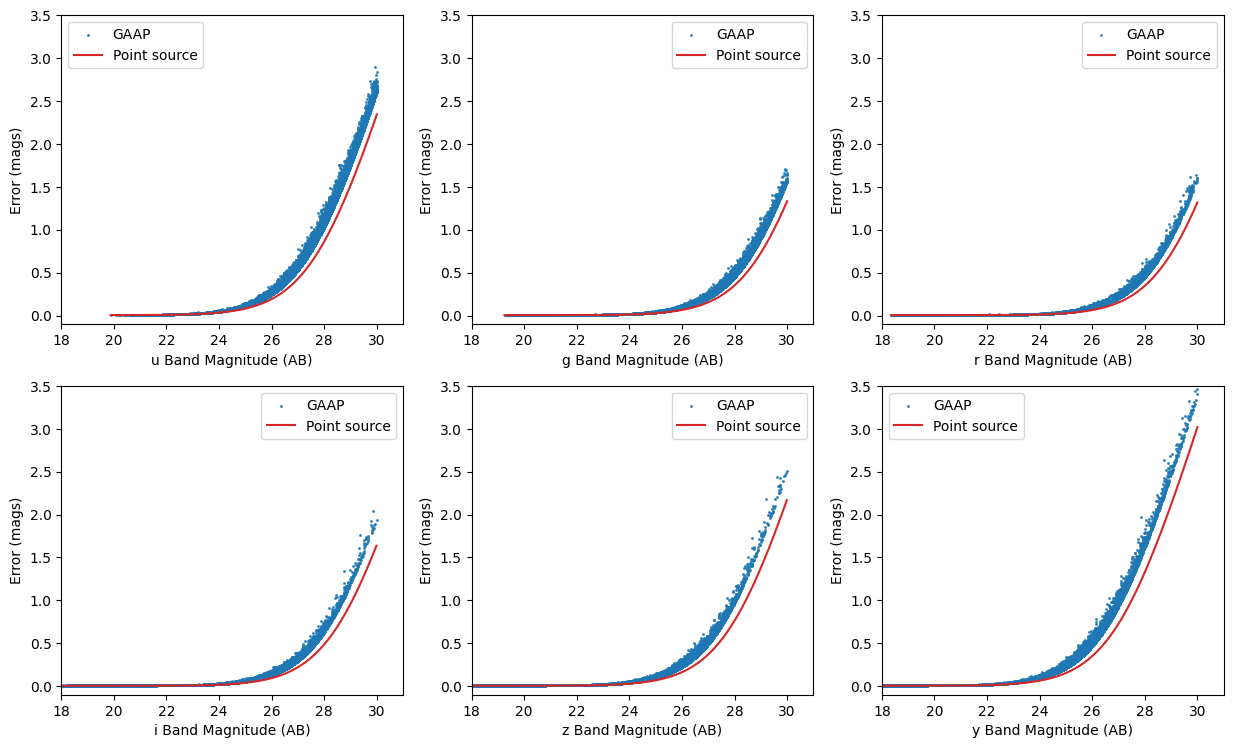

In [14]:
%matplotlib inline

fig, axes_ = plt.subplots(ncols=3, nrows=2, figsize=(15, 9), dpi=100)
axes = axes_.reshape(-1)
for i, band in enumerate("ugrizy"):
    ax = axes[i]
    # pull out the magnitudes and errors
    mags = samples_w_errs.data[band].to_numpy()
    errs = samples_w_errs.data[band + "_err"].to_numpy()
    
    # sort them by magnitude
    mags, errs = mags[mags.argsort()], errs[mags.argsort()]
    
    # plot errs vs mags
    #ax.plot(mags, errs, label=band) 
    
    #plt.plot(mags, errs, c='C'+str(i))
    ax.scatter(samples_w_errs_gaap.data[band].to_numpy(),
            samples_w_errs_gaap.data[band + "_err"].to_numpy(),
                s=5, marker='.', color='C0', alpha=0.8, label='GAAP')
    
    ax.plot(mags, errs, color='C3', label='Point source')
    
    
    ax.legend()
    ax.set_xlim(18, 31)
    ax.set_ylim(-0.1, 3.5)
    ax.set(xlabel=band+" Band Magnitude (AB)", ylabel="Error (mags)")


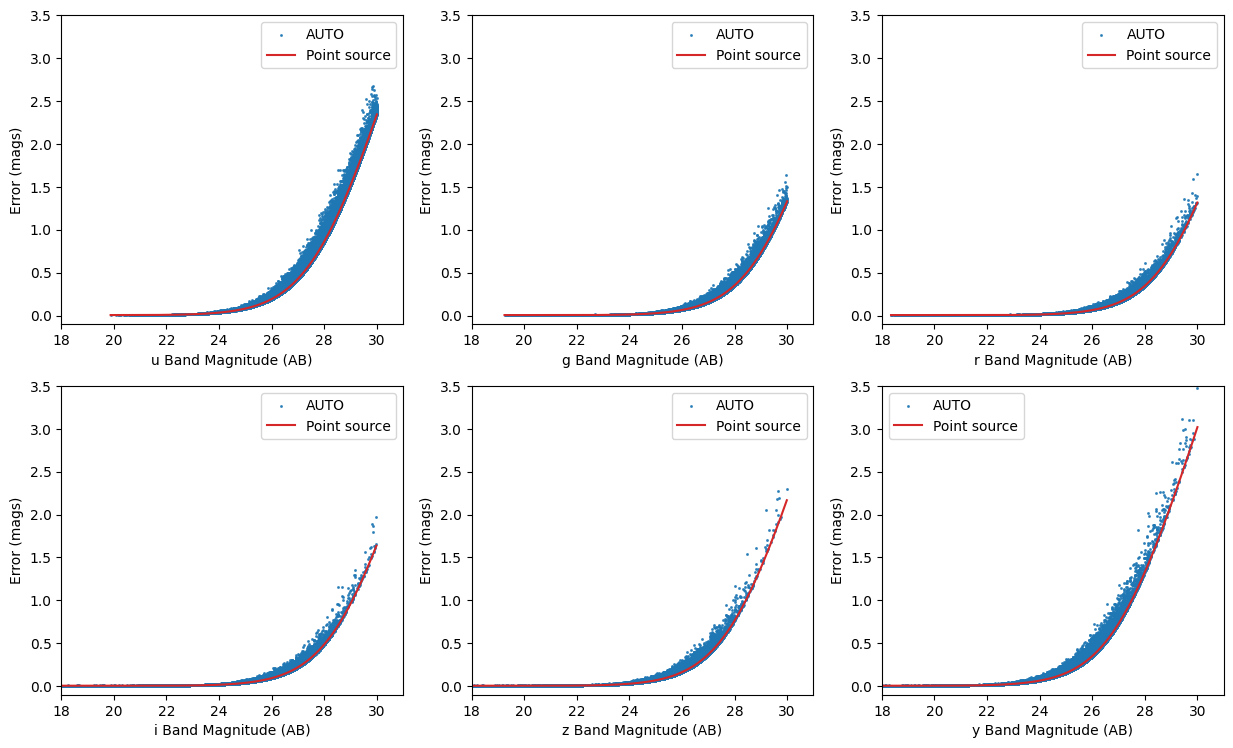

In [15]:
%matplotlib inline

fig, axes_ = plt.subplots(ncols=3, nrows=2, figsize=(15, 9), dpi=100)
axes = axes_.reshape(-1)
for i, band in enumerate("ugrizy"):
    ax = axes[i]
    # pull out the magnitudes and errors
    mags = samples_w_errs.data[band].to_numpy()
    errs = samples_w_errs.data[band + "_err"].to_numpy()
    
    # sort them by magnitude
    mags, errs = mags[mags.argsort()], errs[mags.argsort()]
    
    # plot errs vs mags
    #ax.plot(mags, errs, label=band) 
    
    #plt.plot(mags, errs, c='C'+str(i))
    ax.scatter(samples_w_errs_auto.data[band].to_numpy(),
            samples_w_errs_auto.data[band + "_err"].to_numpy(),
                s=5, marker='.', color='C0', alpha=0.8, label='AUTO')
    
    ax.plot(mags, errs, color='C3', label='Point source')
    
    
    ax.legend()
    ax.set_xlim(18, 31)
    ax.set_ylim(-0.1, 3.5)
    ax.set(xlabel=band+" Band Magnitude (AB)", ylabel="Error (mags)")


You can see that the photometric error increases as magnitude gets dimmer, just like you would expect. Notice, however, that we have galaxies as dim as magnitude 30. This is because the Flow produces a sample much deeper than the LSST 5-sigma limiting magnitudes. There are no galaxies dimmer than magnitude 30 because LSSTErrorModel sets magnitudes > 30 equal to NaN (the default flag for non-detections).

Also, you can find the GAaP and AUTO magnitude error are scattered due to variable galaxy sizes. Also, you can find that there are gaps between GAAP magnitude error and point souce magnitude error, this is because the additional factors due to aperture sizes have a minimum value of $\sqrt{(\sigma^2+A_{\mathrm{min}})/\sigma^2}$, where $\sigma$ is the width of the beam, $A_{\min}$ is an offset of the aperture sizes (taken to be 0.7 arcmin here).

<a id="QuantityCut"></a>
## Degrader 2: QuantityCut

Recall how the sample above has galaxies as dim as magnitude 30. This is well beyond the LSST 5-sigma limiting magnitudes, so it will be useful to apply cuts to the data to filter out these super-dim samples. We can apply these cuts using the `QuantityCut` degrader. This degrader will cut out any samples that do not pass all of the specified cuts.

Let's make and run degraders that first adds photometric errors, then cuts at i<25.3, which is the LSST gold sample.

In [16]:
gold_cut = QuantityCut.make_stage(name='cuts', cuts={"i": 25.3})                                

Now we can stick this into a Creator and draw a new sample

In [17]:
samples_gold_w_errs = gold_cut(samples_w_errs)

Inserting handle into data store.  output_cuts: inprogress_output_cuts.pq, cuts


If you look at the i column, you will see there are no longer any samples with i > 25.3. The number of galaxies returned has been nearly cut in half from the input sample and, unlike the LSSTErrorModel degrader, is not equal to the number of input objects.  Users should note that with degraders that remove galaxies from the sample the size of the output sample will not equal that of the input sample.

One more note: it is easy to use the QuantityCut degrader as a SNR cut on the magnitudes. The magnitude equation is $m = -2.5 \log(f)$. Taking the derivative, we have
$$
dm = \frac{2.5}{\ln(10)} \frac{df}{f} = \frac{2.5}{\ln(10)} \frac{1}{\mathrm{SNR}}.
$$
So if you want to make a cut on galaxies above a certain SNR, you can make a cut
$$
dm < \frac{2.5}{\ln(10)} \frac{1}{\mathrm{SNR}}.
$$
For example, an SNR cut on the i band would look like this: `QuantityCut({"i_err": 2.5/np.log(10) * 1/SNR})`.

<a id="InvRedshiftIncompleteness"></a>
## Degrader 3: InvRedshiftIncompleteness

Next, we will demonstrate the `InvRedshiftIncompleteness` degrader. It applies a selection function, which keeps galaxies with probability $p_{\text{keep}}(z) = \min(1, \frac{z_p}{z})$, where $z_p$ is the ''pivot'' redshift. We'll use $z_p = 0.8$.

In [18]:
inv_incomplete = InvRedshiftIncompleteness.make_stage(name='incompleteness', pivot_redshift=0.8)

In [19]:
samples_incomplete_gold_w_errs = inv_incomplete(samples_gold_w_errs)

Inserting handle into data store.  output_incompleteness: inprogress_output_incompleteness.pq, incompleteness


Let's plot the redshift distributions of the samples we have generated so far:

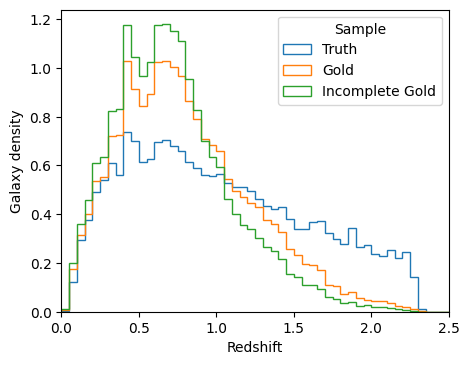

In [20]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

zmin = 0
zmax = 2.5

hist_settings = {
    "bins": 50,
    "range": (zmin, zmax),
    "density": True,
    "histtype": "step",
}

ax.hist(samples_truth()["redshift"], label="Truth", **hist_settings)
ax.hist(samples_gold_w_errs()["redshift"], label="Gold", **hist_settings)
ax.hist(samples_incomplete_gold_w_errs()["redshift"], label="Incomplete Gold", **hist_settings)
ax.legend(title="Sample")
ax.set(xlim=(zmin, zmax), xlabel="Redshift", ylabel="Galaxy density")
plt.show()

You can see that the Gold sample has significantly fewer high-redshift galaxies than the truth. This is because many of the high-redshift galaxies have i > 25.3.

You can further see that the Incomplete Gold sample has even fewer high-redshift galaxies. This is exactly what we expected from this degrader.

<a id="LineConfusion"></a>
## Degrader 4: LineConfusion

`LineConfusion` is a degrader that simulates spectroscopic errors resulting from the confusion of different emission lines.

For this example, let's use the degrader to simulate a scenario in which which 2% of [OII] lines are mistaken as [OIII] lines, and 1% of [OIII] lines are mistaken as [OII] lines. (note I do not know how realistic this scenario is!)

In [21]:
OII = 3727
OIII = 5007

lc_2p_0II_0III = LineConfusion.make_stage(name='lc_2p_0II_0III',
                                          true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02)
lc_1p_0III_0II = LineConfusion.make_stage(name='lc_1p_0III_0II',
                                          true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01)

In [22]:
samples_conf_inc_gold_w_errs = lc_1p_0III_0II(lc_2p_0II_0III(samples_incomplete_gold_w_errs))

Inserting handle into data store.  output_lc_2p_0II_0III: inprogress_output_lc_2p_0II_0III.pq, lc_2p_0II_0III
Inserting handle into data store.  output_lc_1p_0III_0II: inprogress_output_lc_1p_0III_0II.pq, lc_1p_0III_0II


Let's plot the redshift distributions one more time

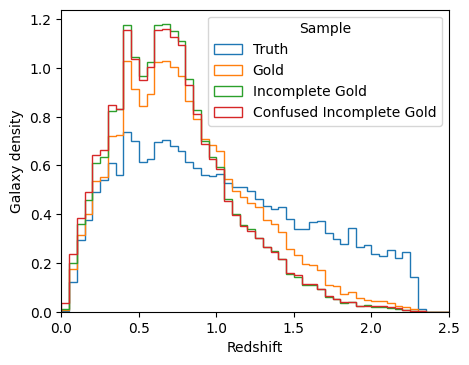

In [23]:
fig, ax = plt.subplots(figsize=(5, 4), dpi=100)

zmin = 0
zmax = 2.5

hist_settings = {
    "bins": 50,
    "range": (zmin, zmax),
    "density": True,
    "histtype": "step",
}

ax.hist(samples_truth()["redshift"], label="Truth", **hist_settings)
ax.hist(samples_gold_w_errs()["redshift"], label="Gold", **hist_settings)
ax.hist(samples_incomplete_gold_w_errs()["redshift"], label="Incomplete Gold", **hist_settings)
ax.hist(samples_conf_inc_gold_w_errs()["redshift"], label="Confused Incomplete Gold", **hist_settings)
ax.legend(title="Sample")
ax.set(xlim=(zmin, zmax), xlabel="Redshift", ylabel="Galaxy density")
plt.show()

You can see that the redshift distribution of this new sample is essentially identical to the Incomplete Gold sample, with small perturbations that result from the line confusion. 

However the real impact of this degrader isn't on the redshift distribution, but rather that it introduces erroneous spec-z's into the photo-z training sets! To see the impact of this effect, let's plot the true spec-z's as present in the Incomplete Gold sample, vs the spec-z's listed in the new sample with Oxygen Line Confusion.

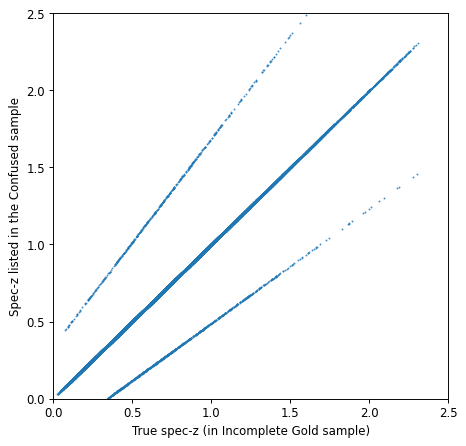

In [24]:
fig, ax = plt.subplots(figsize=(6, 6), dpi=85)

ax.scatter(samples_incomplete_gold_w_errs()["redshift"], samples_conf_inc_gold_w_errs()["redshift"], 
           marker=".", s=1)

ax.set(
    xlim=(0, 2.5), ylim=(0, 2.5),
    xlabel="True spec-z (in Incomplete Gold sample)",
    ylabel="Spec-z listed in the Confused sample",
)
plt.show()

Now we can clearly see the spec-z errors! The galaxies above the line y=x are the [OII] -> [OIII] galaxies, while the ones below are the [OIII] -> [OII] galaxies.